Frente a técnicas de reducción convexas como PCA, que no preservan relaciones entre parejas de datos, el objetivo de esta práctica guiada es comprobar cómo técnicas no convexas, como t-SNE (t-Distributed Stochastic Neighbor Embedding) en ocasiones pueden ser más adecuadas. Para ello, emplearemos la base de datos USArrest, que ofrece el número de delitos de 3 tipos (asalto, homicidio y violación), más el porcentaje de suelo urbano en todos los estados de Norteamérica. Nótese que generalmente se emplean estos métodos con bases de datos muchísimo mayores, pero emplearemos una ligera para ahorrar tiempo de cómputo.

A continuación se adjunta el código comentado.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Cargar los datos USArrests
# URL raw del archivo en GitHub
url = 'https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/USArrests.csv'

# Leer el archivo CSV directamente desde la URL
usa_df = pd.read_csv(url, index_col='Unnamed: 0')

# Mostrar las primeras filas del DataFrame
print(usa_df.head())

            Murder  Assault  UrbanPop  Rape
Alabama       13.2      236        58  21.2
Alaska        10.0      263        48  44.5
Arizona        8.1      294        80  31.0
Arkansas       8.8      190        50  19.5
California     9.0      276        91  40.6


Vamos a comenzar por obtener las componentes principales del dataset, que usaremos como base para comparar técnicas convexas y no convexas.

El código a continuación obtiene las componentes del conjunto de datos y las representa sobre un plano, en este caso usando la componente 1 y la 2 como ejes X e Y respectivamente. Antes de representarlos, dividimos el conjunto escalado de datos (sin proyectar) en tres clases, acorde al parecido entre las cuatro variables originales. Para esto empleamos el algoritmo de clustering K-means. El resultado es que las ciudades quedarán etiquetadas como clase 1, clase 2 o clase 3, con el criterio básico de que los elementos de cada clase se parezcan entre si y se diferencien del resto. Una vez dibujemos las ciudades en función de sus dos primeras componentes en PCA, añadimos el color para identificar la clase.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


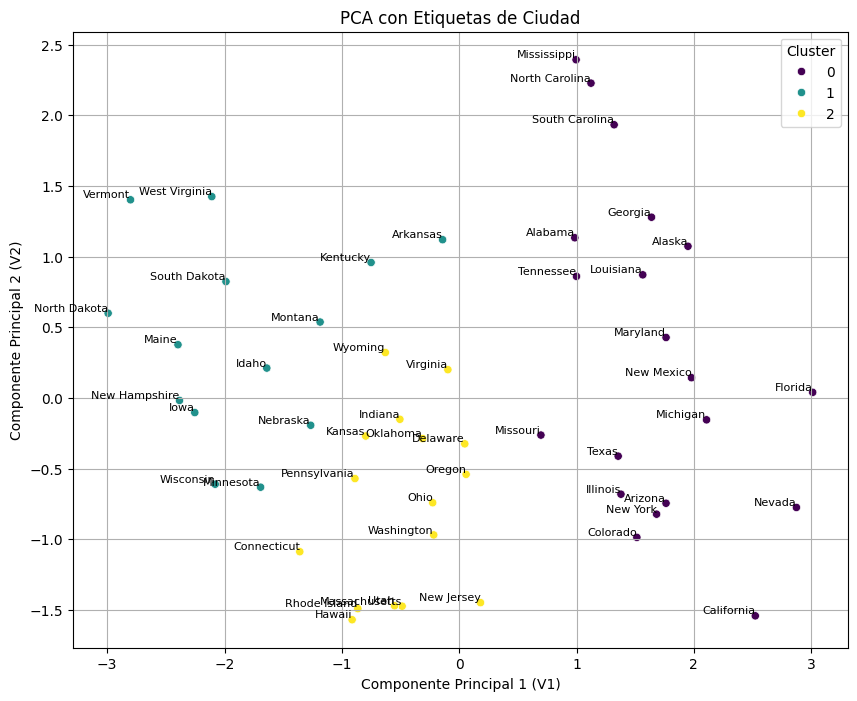

In [6]:
# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(usa_df)

# Realizar Análisis de Componentes Principales (PCA)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Crear un DataFrame para visualización con PCA
pca_df = pd.DataFrame(pca_result, columns=['V1', 'V2'])
pca_df['Ciudad'] = usa_df.index #los nombres de las ciudades son el indice del df

# Obtener etiquetas de clusters utilizando KMeans
kmeans = KMeans(n_clusters=3, random_state=1234)
cluster_labels = kmeans.fit_predict(scaled_data) #1,2 o 3 para 3 clases

# Visualizar PCA con etiquetas de ciudad
plt.figure(figsize=(10, 8))
sns.scatterplot(x='V1', y='V2', data=pca_df, hue=cluster_labels, palette='viridis', legend='full')

# Etiquetar los puntos con nombres de ciudades en el plot de PCA
for i, row in pca_df.iterrows():
    plt.text(row['V1'], row['V2'], row['Ciudad'], fontsize=8, ha='right', va='bottom')

plt.title('PCA con Etiquetas de Ciudad')
plt.xlabel('Componente Principal 1 (V1)')
plt.ylabel('Componente Principal 2 (V2)')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()

Puede observarse que las dos primeras componentes ya muestran cierta relación con los resultados del clustering, esto es, en la parte izquierda se sitúan principalmente ciudades del cluster 1, abajo alrededor del 0 de abcisas están las ciudades del cluster 2 y a la derecha se despliegan las del cluster 3. Esto viene a indicar que podríamos clusterizar usando solo las dos primeras componentes en lugar de las cuatro variables originales.

A continuación, repetimos la operación siguiendo la misma metodología, pero esta vez con una transformación t-SNE

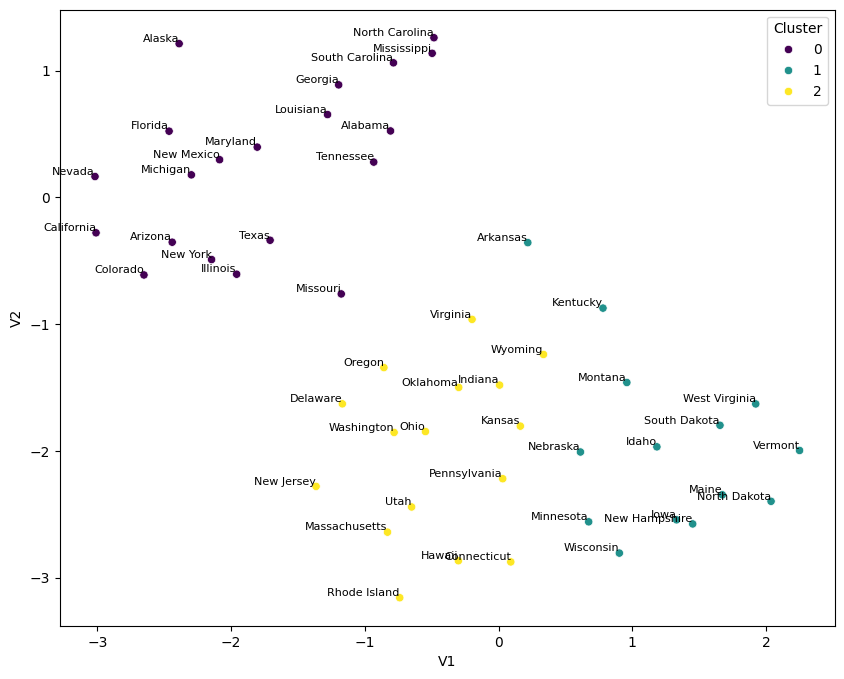

In [23]:
# Realizar t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=1234)
tsne_result = tsne.fit_transform(scaled_data)

# Crear un DataFrame para visualización con t-SNE
tsne_df = pd.DataFrame(tsne_result, columns=['V1', 'V2'])
tsne_df['Cluster'] = cluster_labels
#tsne_df['Cluster'] = KMeans(n_clusters=3, random_state=1234).fit(scaled_data).labels_
tsne_df['Ciudad'] = usa_df.index

# Visualizar t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x='V1', y='V2', hue='Cluster', data=tsne_df, palette='viridis', legend='full')


# Añadir etiquetas de ciudad a los puntos
for _, row in tsne_df.iterrows():
    plt.text(row['V1'], row['V2'], row['Ciudad'], fontsize=8, ha='right', va='bottom')

plt.show()

En este caso también se observan proximidades según el cluster, pero los grupos de ciudades son algo más compactos en relación a la proyección a los ejes y, de hecho, parece apuntarse que tal vez tres grupos son insuficientes para explicar la variabilidad de los datos. Por ejemplo, en el cluster 0 se insinúa un subgrupo que incluye estados de los denominados "del Sur". En este punto, podría ser interesante analizar la diferencia entre proporciones de delitos y características geopolíticas de las agrupaciones que aparecen.

Nótese que los resultados dependen del parámetro **perplexity**, que indica cuántos vecinos se consideran relevantes en la optimización. En este sentido, valores altos de perplexity mejoran la estabilidad y hacen que emerjan estructuras globales, mientras que los valores bajos impulsan la aparición de estructuras locales.

Por último, por comprobar el efecto de la reducción convexa y no convexa en predicción, vamos a a combinar todos los datos que tenemos en un único dataframe. Incluimos la clase original que se asigno a los datos mediante K-means como identificador de grupo a que pertenece cada ciudad. Recordemos que este cluster se efectuó usando todas las variables del principio, sin proyectar en ningún espacio.

In [24]:
# Combino toda la informacion que tengo en un unico dataframe.

combined_df= pd.concat([pca_df.iloc[:, 0:2], tsne_df],
                  axis = 1)

combined_df.columns = ['PC1', 'PC2', 'SNE1', 'SNE2'] + list(tsne_df.columns[2:])
combined_df.index = usa_df.index

combined_df = pd.concat([usa_df, combined_df.iloc[:,0:5]], axis=1)

# Mostrar las primeras filas del DataFrame final
print(combined_df.head())

            Murder  Assault  UrbanPop  Rape       PC1       PC2      SNE1  \
Alabama       13.2      236        58  21.2  0.985566  1.133392 -0.808065   
Alaska        10.0      263        48  44.5  1.950138  1.073213 -2.388430   
Arizona        8.1      294        80  31.0  1.763164 -0.745957 -2.440276   
Arkansas       8.8      190        50  19.5 -0.141420  1.119797  0.218322   
California     9.0      276        91  40.6  2.523980 -1.542934 -3.009817   

                SNE2  Cluster  
Alabama     0.524532        0  
Alaska      1.213148        0  
Arizona    -0.353324        0  
Arkansas   -0.356747        1  
California -0.279264        0  


Ahora vamos a probar a hacer predicción lineal de a qué clase creemos que debería pertenecer cada ciudad dadas:


1.   Las 4 variables originales
2.   La proyección en dos componentes PCA
3.   La proyección en dos componentes TSNE


In [25]:
# Definir conjuntos de características para cada caso
features_sets = {
    'Case 1': ['Murder', 'Assault', 'UrbanPop', 'Rape'],
    'Case 2': ['PC1', 'PC2'],
    'Case 3': ['SNE1', 'SNE2']
}

# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(combined_df[features_sets['Case 1'] + features_sets['Case 2'] + features_sets['Case 3']],
                                                    combined_df['Cluster'],
                                                    test_size=0.20,
                                                    random_state=1234)

# Función para entrenar y evaluar el modelo de regresión lineal
def train_and_evaluate(features):
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Inicializar y entrenar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_train_subset, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_subset)

    # Calcular métricas de evaluación (R² y MSE)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    return r2, mse

# Iterar sobre cada caso de características y entrenar/evaluar el modelo
results = {}
for case_name, features in features_sets.items():
    r2score, mse_score = train_and_evaluate(features)
    results[case_name] = {'R²': r2score, 'MSE': mse_score}

# Mostrar los resultados de las métricas para cada caso
for case_name, metrics in results.items():
    print(f"Metrics for {case_name}:")
    print(f"  R² Score: {metrics['R²']:.4f}")
    print(f"  Mean Squared Error (MSE): {metrics['MSE']:.4f}")
    print("")


Metrics for Case 1:
  R² Score: 0.0186
  Mean Squared Error (MSE): 0.6379

Metrics for Case 2:
  R² Score: 0.0103
  Mean Squared Error (MSE): 0.6433

Metrics for Case 3:
  R² Score: 0.0669
  Mean Squared Error (MSE): 0.6065



Puede observarse que el error de predicción es ligeramente más bajo en en caso de t-SNE, aunque estamos trabajando con la mitad del volumen de datos original. Además, el coeficiente de determinación R2 es significativamente más alto.